In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import csv
import time
import datetime

from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from matplotlib.colors import ListedColormap

from DataSet import DataSet

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


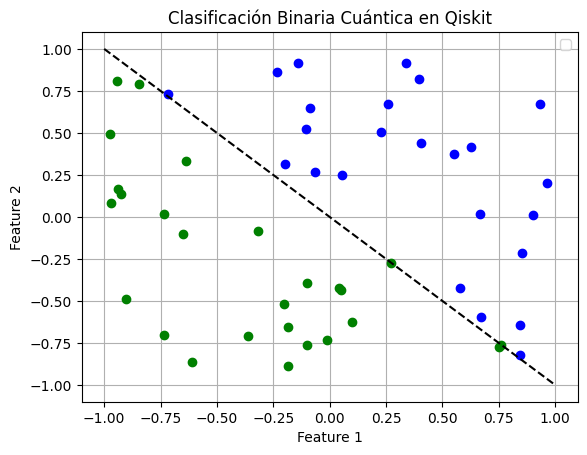

In [2]:
#Instanciamos la clase DataSet y mostramos un diagrama los datos
dataset = DataSet(seed=40)
dataset.Draw()

In [3]:
dev = qml.device("default.qubit")

In [4]:
def layer(layer_weights):
    for wire in range(1):
        qml.Rot(*layer_weights[wire], wires=wire)

    qml.CNOT([0, 1])

In [5]:
def state_preparation(x):
    #ZZ FEATURE MAP
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.PhaseShift((2 * x[0]), wires=0)
    qml.PhaseShift((2 * x[0]), wires=0)
    qml.CNOT(wires=[0, 1])
    qml.PhaseShift((2 * (np.pi - x[0]) * (np.pi - x[0])) , wires=0)
    qml.CNOT(wires=[0, 1])
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.PhaseShift((2 * x[0]), wires=0)
    qml.PhaseShift((2 * x[0]), wires=0)
    qml.CNOT(wires=[0, 1])
    qml.PhaseShift((2 * (np.pi - x[0]) * (np.pi - x[0])) , wires=0)
    qml.CNOT(wires=[0, 1])
    '''
    #Circuit 1
    qml.RY(x[0], wires=0)
    qml.RY(x[0], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[0], wires=0)
    qml.RY(x[0], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[0], wires=0)
    qml.RY(x[0], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[0], wires=0)
    qml.RY(x[0], wires=1)
    
    #Circuit 2
    qml.RY(x[0], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[0], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.X(wires=0)
    qml.RY(x[0], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[0], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.X(wires=0)
    qml.RY(x[0], wires=1)
    '''
    #Circuit 3
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RZ(x[0], wires=0)
    qml.RZ(x[0], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.Hadamard(wires=0)
    

In [6]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)
    
    for layer_weights in weights:
        layer(layer_weights)
    
    return qml.expval(qml.PauliZ(0))

In [7]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [8]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [9]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [10]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [11]:
score_list = []

with open('datos_entrenamiento_circuito3_50samples.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(['Fecha', 'Hora', 'Tiempo de ejecucción', 'Score', 'Libreria'])

    for i in range(100):
        start = time.time()
    
        np.random.seed(0)
        num_qubits = 2
        num_layers = 2
        weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
        bias_init = np.array(0.0, requires_grad=True)
        
        print("Weights:", weights_init)
        print("Bias: ", bias_init)
        
        opt = NesterovMomentumOptimizer(0.5)
        batch_size = 5
        
        weights = weights_init
        bias = bias_init
        
        # Update the weights by one optimizer step, using only a limited batch of data
        batch_index = np.random.randint(0, len(dataset.y01), (batch_size,))
        X_batch = dataset.y01[batch_index]
        Y_batch = dataset.y[batch_index]
        
        # Compute accuracy
        predictions = [np.sign(variational_classifier(weights, bias, dataset.y01)) for x in dataset.y01]
        
        #current_cost = cost(weights, bias, dataset.y01, dataset.y)
        acc = accuracy(dataset.y, predictions)
        
        print(f"Iter: {1}  | Accuracy: {acc:0.7f}")
        
        misclassified_indices = []
        
        # Calcula las predicciones para cada punto y almacena los índices de los mal clasificados
        predictions = [np.sign(variational_classifier(weights, bias, x)) for x in dataset.X_aux]
        for idx, (prediction, label) in enumerate(zip(predictions, dataset.y)):
            if prediction != label:
                misclassified_indices.append(idx)
        
        # Plotea los datos
        plt.figure(figsize=(8, 6))
        plt.scatter(dataset.X_aux[:, 0], dataset.X_aux[:, 1], c=dataset.y, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), marker='o', edgecolors='k', label='Datos')
        
        # Plotea los puntos clasificados incorrectamente
        incorrectly_classified = dataset.X_aux[misclassified_indices]
        plt.scatter(incorrectly_classified[:, 0], incorrectly_classified[:, 1], c='red', marker='x', s=100, label='Clasificados incorrectamente')
        
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Clasificación Binaria Cuántica')
        plt.legend()
        plt.grid(True)
        plt.show()

        end = time.time()
        tiempo_ejecuccion = end - start

        now = datetime.datetime.now()
        fecha = now.strftime("%Y-%m-%d")
        hora = now.strftime("%H:%M:%S")
        libreria = 'Pennylane'

        writer.writerow([fecha, hora, tiempo_ejecuccion, acc, libreria])
        score_list.append(acc)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]]

 [[ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]]
Bias:  0.0
Iter: 1  | Accuracy: 0.4800000


KeyboardInterrupt: 

In [ ]:
print(score_list)